# Check the distribution of the railhead above ground

In [28]:
import pdal 
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import os
import json
import pyvista as pv

from interessant import * # Bei Änderungen Kernel neu starten

In [29]:
run = run24
#run = run14
# filename = interessant['OLA gleiche Höhe wie Gleis']

# Bahnsteig: 29; Gleis hohe Intensität: 11; Weiche B: 16; Unterirdischer Bhf: 20; Gleis weit abseits: 23; Betondeckel: 28; Zug run 14 A (in run24 Achszähler): 6; 
# Viele Gleise: 33; Anfang Weiche: 34, OLA gleiche H: 35; Y: 37
key = list(interessant.keys())[0] 
filename = interessant[key]
print(key, filename)


filename = os.path.join(run, filename)
if not os.path.exists(filename):
    raise FileNotFoundError(filename)

Einfach 4473900_5335875.copc.laz


In [30]:
thresh = 20  # z.B. 5 oder 8
majority_tresh  = 0.7# 0.7  # 0.7 0.5 # Erster Durchgang 0.3, bei "Gleis hohe Intensität" gibt 0.5 ein viel besseres Ergebnis
ground_percentile = 10 # 10 # 10 in Oude E.

voxel_size = 1.0

voxel_size = 25 / 30
print("Voxel size:", voxel_size)

minimum_points = 50 # Erste Versuche mit 100, aber viel schwarz bei abseits liegenden Gleisen. 50 ist besser.

with_normals = False

Voxel size: 0.8333333333333334


In [31]:
import subprocess
# subprocess.Popen(["pyvistaviewer", filename])

In [32]:
pipeline = pdal.Pipeline([pdal.Reader(filename)])
pipeline.execute()
points = pipeline.arrays[0]
points.dtype # Column names and types

dtype([('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('ReturnNumber', 'u1'), ('NumberOfReturns', 'u1'), ('ScanDirectionFlag', 'u1'), ('EdgeOfFlightLine', 'u1'), ('Classification', 'u1'), ('Synthetic', 'u1'), ('KeyPoint', 'u1'), ('Withheld', 'u1'), ('Overlap', 'u1'), ('ScanAngleRank', '<f4'), ('UserData', 'u1'), ('PointSourceId', '<u2'), ('GpsTime', '<f8'), ('ScanChannel', 'u1'), ('Red', '<u2'), ('Green', '<u2'), ('Blue', '<u2')])

In [33]:
metadata = pipeline.metadata['metadata']
metadata['readers.copc']['maxx']

4473925

In [34]:
def pipeline_bbox(pipeline):
    """Return 2D bounding box of the point cloud"""
    metadata = pipeline.metadata['metadata']
    key = None
    for k in metadata.keys():
        if k.startswith('readers'):
            key = k
    if not key:
        raise ValueError("No readers found")
    maxx = metadata[key]['maxx']
    minx = metadata[key]['minx']
    maxy = metadata[key]['maxy']
    miny = metadata[key]['miny']

    return minx, miny, maxx, maxy

In [35]:
pipeline_bbox(pipeline)

(4473900, 5335875, 4473925, 5335900)

In [36]:
points['Classification'] = 0 # Unclassified

In [37]:
xyz = np.vstack((points['X'], points['Y'], points['Z'])).transpose()
rgb = np.vstack((points['Red'], points['Green'], points['Blue'])).transpose() / 65535.0

intensity = points['Intensity']
intensity_normalized = (intensity - intensity.min()) / (intensity.max() - intensity.min())
colormap = plt.get_cmap("viridis")
intensity_colors = colormap(intensity_normalized)
intensity_colors = intensity_colors[:, :3]

# Offset entfernen (aber gerundet, damit Kachelgrenzen ganze Zahlen bleiben)
offset = xyz.mean(axis=0).round() 
xyz -= offset

In [38]:
offset

array([4.473913e+06, 5.335888e+06, 5.170000e+02])

In [39]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
# pcd.colors = o3d.utility.Vector3dVector(intensity_colors)
# pcd.colors = o3d.utility.Vector3dVector(rgb)

In [40]:
# o3d.visualization.draw_geometries([pcd])

# Teile in säulenartige Voxel, um darin z zu untersuchen

In [41]:
maxp = xyz.max(axis=0)
minp = xyz.min(axis=0)
maxp, minp

(array([11.99997543, 11.99998693, 13.12408   ]),
 array([-13.00002457, -13.00001307,  -3.99652   ]))

In [42]:
my_classes = {
    "Unclassified": 0,
    "High Points": 13,   
    "No clearance": 14,
    "Missing Rail": 15,
    "Low Points": 16,
    "Rail": 20,
}

color_map = {
    13: [0.3, 0.3, 0.3],
    14: [0.5, 0.5, 0.5], 
    15: [0, 0, 1],
    16: [0, 1, 0],
    20: [1, 0, 0],
}

In [43]:
voxels = xyz.copy()
voxels[:, :2] = ((xyz[:, :2] - minp[:2]) // voxel_size).astype(int)

In [44]:
# Anzahl der Voxel checken
np.ceil((maxp[:2] - minp[:2]) / voxel_size).astype(int)

array([30, 30])

Die folgende Zelle benötigt bei Kachel "Einfach" 5.8 s.

In [47]:
from collections import defaultdict
voxel_dict = defaultdict(list)
index_dict = defaultdict(list)

# Füllen des Dictionaries
for idx, (point, voxel) in enumerate(zip(xyz, voxels)):
    voxel_key = tuple(voxel[:2])
    voxel_dict[voxel_key].append(point[2])
    index_dict[voxel_key].append(idx)

In [48]:
# Viewsettings mit strg + c kopieren und hier einfügen

viewsettings = '''
{
	"class_name" : "ViewTrajectory",
	"interval" : 29,
	"is_loop" : false,
	"trajectory" : 
	[
		{
			"boundingbox_max" : [ 11.999975427985191, 11.99998692702502, 13.124079998226534 ],
			"boundingbox_min" : [ -13.000024572014809, -13.00001307297498, -3.9965200017734333 ],
			"field_of_view" : 60.0,
			"front" : [ -0.20468464372193082, -0.82045900926496551, 0.53380821531742795 ],
			"lookat" : [ -2.1145501200370735, -2.6052610037108783, 1.4494799802055294 ],
			"up" : [ 0.19010212482081987, 0.50164960558000959, 0.84392467398461002 ],
			"zoom" : 0.55999999999999983
		}
	],
	"version_major" : 1,
	"version_minor" : 0
}

'''

viewsettings = json.loads(viewsettings)

front = viewsettings["trajectory"][0]["front"]
lookat = viewsettings["trajectory"][0]["lookat"]
up = viewsettings["trajectory"][0]["up"]
zoom = viewsettings["trajectory"][0]["zoom"]

In [49]:

railtop_above_ground = []

for key, z_values in voxel_dict.items():
    
    # Threshold on number of points in voxel
    if len(z_values) < minimum_points:
        continue

    indices = np.array(index_dict[key])
    z_values = np.array(z_values)
    ground_level = np.percentile(z_values, ground_percentile) # 10% Percentile in Oude E.
    # Check that there are almost no points 0.5 to 4.5 m above the ground
    # But allow for some noise
    count = ((z_values > ground_level + 0.5) & (z_values < ground_level + 4.5)).sum()

    if count <= thresh:
        # Look for points within 0.5 m above ground and get 98% percentile ODER 99.5
        mask = (z_values > ground_level) & (z_values < ground_level + 0.5)
        try:
            candidates_top = np.percentile(z_values[mask], 99.5) 
        except IndexError:
            # Fails if there are no points in the masked array
            continue

        # Oude Elberink require the height difference > 0.1 m
        # And mark only the points 10 cm below the top as rail point candidates
        if candidates_top - ground_level > 0.1:
            mask = (z_values > candidates_top - 0.1) & (z_values < candidates_top + 0.005)

            # Also make sure these are only a minority of the points (otherwise it's a slope)
            if mask.sum() < majority_tresh * len(z_values):  # z.B. 0.3
                railtop_above_ground.append(candidates_top - ground_level)
                


In [50]:
railtop_above_ground = np.array(railtop_above_ground)

In [51]:
print("Min :", railtop_above_ground.min())
print("Max :", railtop_above_ground.max())
print("Mean:", railtop_above_ground.mean())
print("Median:", np.median(railtop_above_ground))
print("Std  :", railtop_above_ground.std())
print("Anzahl:", len(railtop_above_ground))

Min : 0.10943750000000407
Max : 0.49759549999994435
Mean: 0.264330354984892
Median: 0.2261999999999489
Std  : 0.1023401272846818
Anzahl: 331


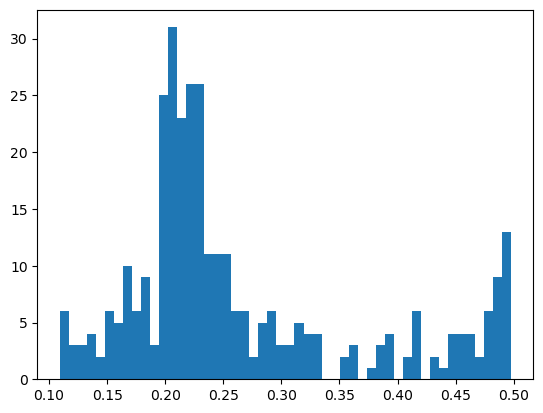

In [52]:
plt.hist(railtop_above_ground, bins=50);